# Real-World Graphs

In [ ]:
DS = pd.read_csv("IC_APPROX_DATASET.csv")
DS["pearson"] = (
    DS["pearson"]
    .astype(str)
    .str.replace(r"tensor\(|\)", "", regex=True)
    .astype(float)
)

In [54]:
DS[(DS["dataset"]=="Epinions") & (DS["edge_method"]=="random_0.1") & (DS["prob_selected"]==0.01)].groupby(["approximation"])["rmse"].median()

approximation
ALE_heuristic    0.116337
Naive            0.076533
SWE              0.002162
dmp_ic_fast      0.076527
dmp_inf          0.002130
dmp_um_fast      0.076542
modified_ALE     0.057669
um_IC            0.002887
Name: rmse, dtype: float64

In [84]:
DS.groupby(["approximation"])["rmse"].max()

approximation
ALE_heuristic    0.564793
Naive            0.487041
SWE              0.052817
dmp_ic_fast      0.430198
dmp_inf          0.051840
dmp_um_fast      0.431252
modified_ALE     0.200026
um_IC            0.068594
Name: rmse, dtype: float64

In [17]:
DS.describe()

,prob_selected,time_mc,T,L,time_ic_apporx,rmse,pearson,spearman,auc
count,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000
mean,0.103333,993.555173,5.848958,0.315104,0.798706,0.103277,0.875722,0.910499,0.953269
std,0.077613,1154.232105,3.132583,0.925560,1.257394,0.115826,0.220965,0.144660,0.099837
min,0.010000,7.951326,1.000000,0.000000,0.042847,0.000709,0.006800,0.159030,0.485070
25%,0.010000,242.331873,3.000000,0.000000,0.096997,0.014291,0.863600,0.897559,0.969259
50%,0.100000,275.483158,5.000000,0.000000,0.430902,0.048865,0.986750,0.980576,0.997806
75%,0.200000,1486.016061,10.000000,0.000000,0.848027,0.177607,0.998525,0.998273,0.999556
max,0.200000,3606.862111,10.000000,5.000000,6.904715,0.564793,1.000000,0.999908,0.999999


In [85]:
DS.info

<bound method DataFrame.info of        dataset  prob_selected   edge_method      time_mc  approximation   T  \
0     Advogato           0.01    random_0.1   228.344927            SWE   8   
1     Advogato           0.01    random_0.1   228.344927          um_IC   9   
2     Advogato           0.01    random_0.1   228.344927    dmp_um_fast   8   
3     Advogato           0.01    random_0.1   228.344927          Naive   8   
4     Advogato           0.01    random_0.1   228.344927    dmp_ic_fast   7   
...        ...            ...           ...          ...            ...  ..   
3835  Epinions           0.20  degree_based  1982.717057          Naive   9   
3836  Epinions           0.20  degree_based  1982.717057    dmp_ic_fast  10   
3837  Epinions           0.20  degree_based  1982.717057        dmp_inf  10   
3838  Epinions           0.20  degree_based  1982.717057   modified_ALE   3   
3839  Epinions           0.20  degree_based  1982.717057  ALE_heuristic   2   

      L  time_ic_ap

In [71]:
df = DS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "time_ic_apporx" in df.columns and "time_ic_approx" not in df.columns:
    df = df.rename(columns={"time_ic_apporx": "time_ic_approx"})

df = df.copy()
df["speedup"] = df["time_mc"] / df["time_ic_approx"]
df["log_speedup"] = np.log10(df["speedup"])
df["log_time_ic_approx"] = np.log10(df["time_ic_approx"])

group_cols = ["dataset", "prob_selected", "edge_method"]
df["rmse_z"] = df["rmse"] / (df.groupby(group_cols)["rmse"].transform("std").replace(0, np.nan))


In [82]:
metrics = ["rmse", "spearman", "pearson", "auc", "time_ic_approx", "speedup"]

summary = (df[df["dataset"]=="Epinions"].groupby(["approximation"])
             .agg(
                 rmse_median=("rmse", "median"),
                 spearman_median=("spearman", "median"),
                 time_median=("time_ic_approx", "median"),
                 pearson_median=("pearson", "median"),
                 auc_median=("auc", "median"),
                 speedup_median=("speedup", "median"),
                 time_mc_median=("time_mc", "median")
             )
             .sort_values(["rmse_median", "time_median"])
          )

#print(summary)
summary

,rmse_median,spearman_median,time_median,pearson_median,auc_median,speedup_median,time_mc_median
approximation,,,,,,,
dmp_inf,0.008057,0.999600,6.580920,0.99980,0.999910,474.066094,3109.137965
SWE,0.008942,0.999292,0.809788,0.99965,0.999789,3799.872423,3109.137965
um_IC,0.016290,0.998740,0.825962,0.99800,0.999641,3641.273209,3109.137965
modified_ALE,0.071549,0.987479,0.728944,0.97980,0.980960,4366.126584,3109.137965
ALE_heuristic,0.201410,0.944893,0.686309,0.88095,0.978652,4598.126047,3109.137965
dmp_ic_fast,0.219223,0.821816,2.058000,0.75230,0.973194,1530.283610,3109.137965
Naive,0.219265,0.821881,1.572747,0.75220,0.973207,1977.238687,3109.137965
dmp_um_fast,0.219301,0.821068,3.415873,0.75175,0.973186,914.337616,3109.137965


/tmp/ipykernel_745143/78039953.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


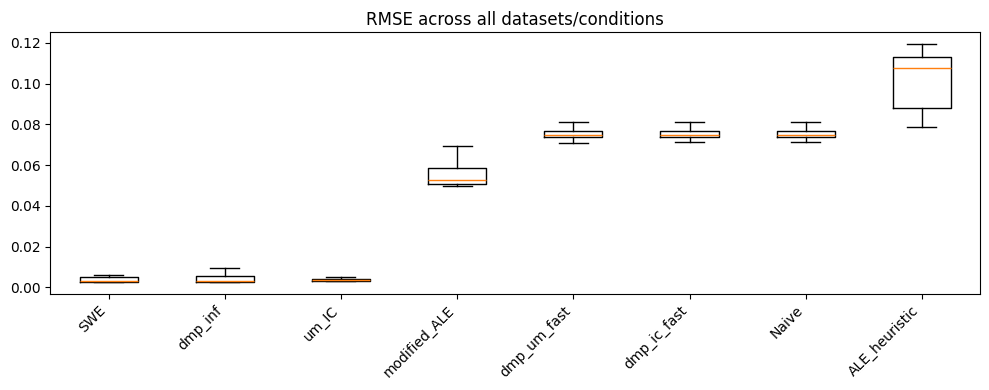

/tmp/ipykernel_745143/78039953.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


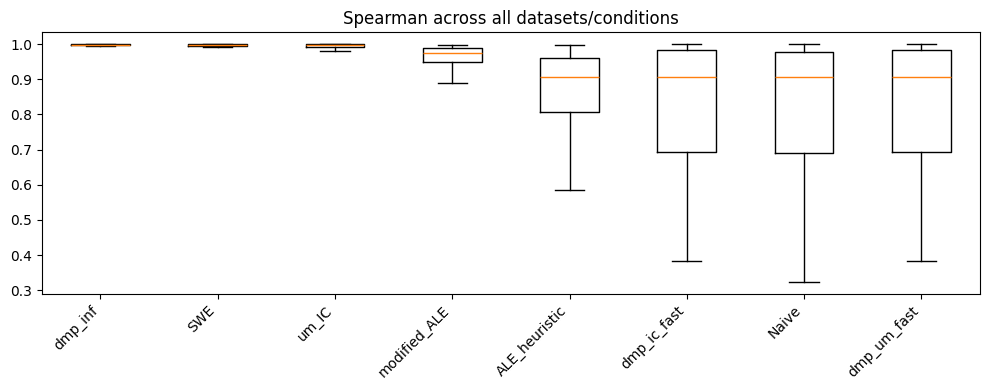

/tmp/ipykernel_745143/78039953.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


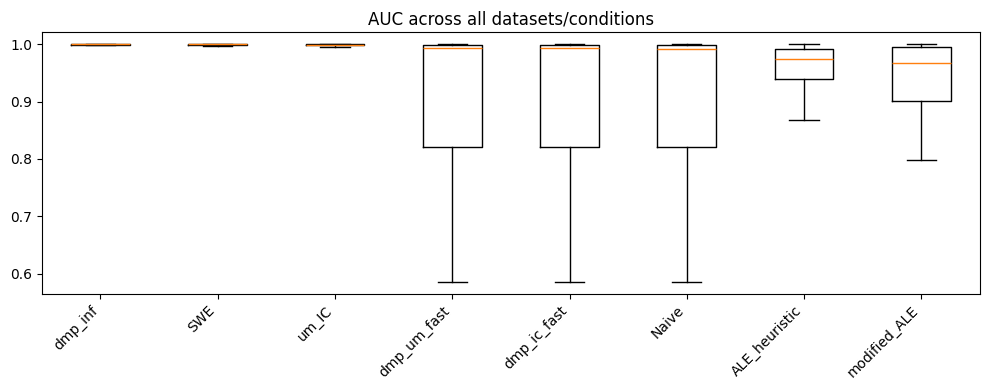

/tmp/ipykernel_745143/78039953.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


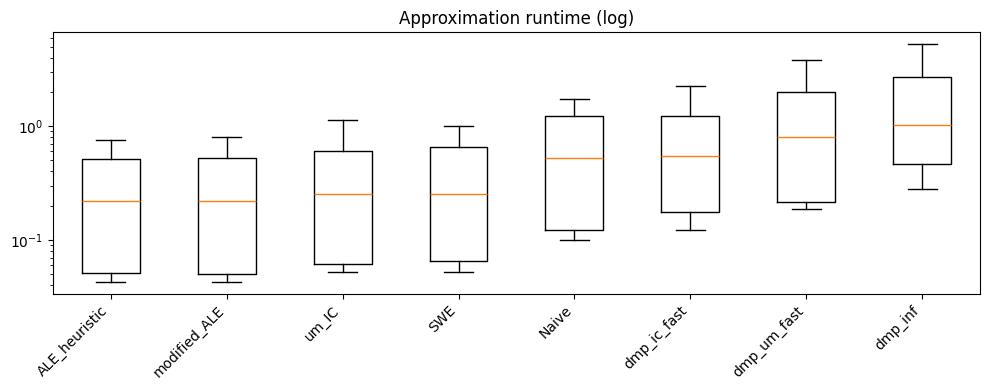

/tmp/ipykernel_745143/78039953.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


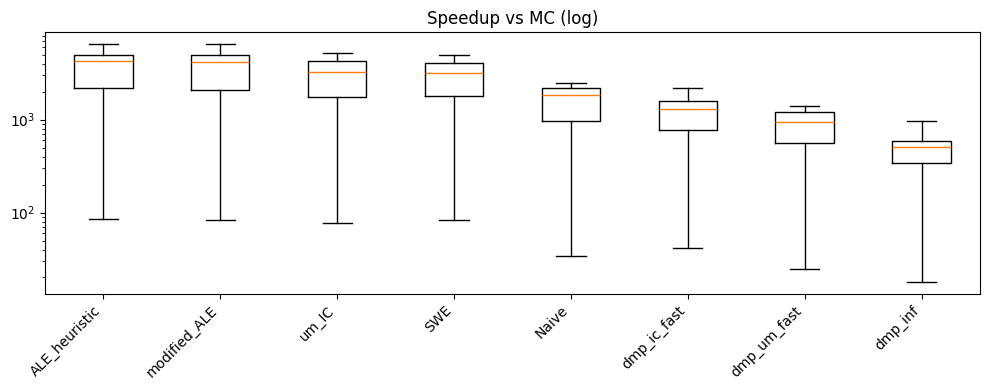

In [50]:
def boxplot_metric(df, metric, by="approximation", title=None, logy=False):
    order = (df.groupby(by)[metric].median().sort_values().index.tolist()
             if metric in ["rmse", "time_ic_approx"] else
             df.groupby(by)[metric].median().sort_values(ascending=False).index.tolist())

    data = [df.loc[df[by] == k, metric].dropna().values for k in order]

    plt.figure(figsize=(10, 4))
    plt.boxplot(data, labels=order, showfliers=False)
    plt.xticks(rotation=45, ha="right")
    if logy:
        plt.yscale("log")
    plt.title(title or f"{metric} by {by}")
    plt.tight_layout()
    plt.show()

boxplot_metric(df[(df["dataset"]=="Anybeat") & (df["edge_method"]=="random_0.1") & (df["prob_selected"]==0.01)], 
               "rmse", title="RMSE across all datasets/conditions")
boxplot_metric(df, "spearman", title="Spearman across all datasets/conditions")
boxplot_metric(df, "auc", title="AUC across all datasets/conditions")
boxplot_metric(df, "time_ic_approx", title="Approximation runtime (log)", logy=True)
boxplot_metric(df, "speedup", title="Speedup vs MC (log)", logy=True)

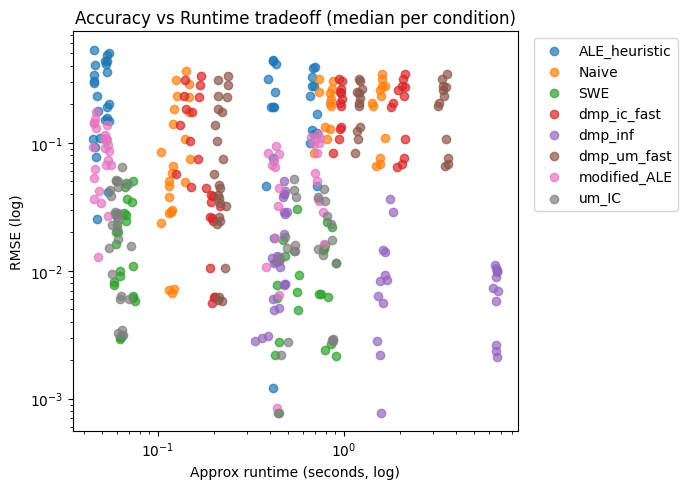

In [35]:
# Aggregate to reduce clutter (median within each condition)
agg_cols = ["dataset", "prob_selected", "edge_method", "approximation"]
plot_df = (df.groupby(agg_cols)
             .agg(rmse=("rmse", "median"),
                  spearman=("spearman", "median"),
                  auc=("auc", "median"),
                  time_ic_approx=("time_ic_approx", "median"),
                  speedup=("speedup", "median"))
             .reset_index())

plt.figure(figsize=(7, 5))
for appr, g in plot_df.groupby("approximation"):
    plt.scatter(g["time_ic_approx"], g["rmse"], label=appr, alpha=0.7)

plt.xscale("log")
plt.yscale("log")  # rmse often benefits from log scale too
plt.xlabel("Approx runtime (seconds, log)")
plt.ylabel("RMSE (log)")
plt.title("Accuracy vs Runtime tradeoff (median per condition)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

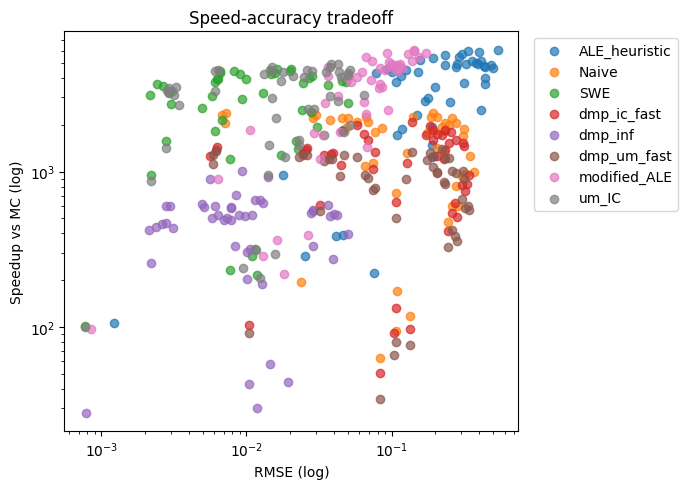

In [31]:
plt.figure(figsize=(7, 5))
for appr, g in plot_df.groupby("approximation"):
    plt.scatter(g["rmse"], g["speedup"], label=appr, alpha=0.7)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("RMSE (log)")
plt.ylabel("Speedup vs MC (log)")
plt.title("Speed-accuracy tradeoff")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [32]:
def winner_counts(df, metric, higher_is_better):
    cols = ["dataset", "prob_selected", "edge_method"]
    g = df.copy()

    # Choose winner per condition
    if higher_is_better:
        winners = g.loc[g.groupby(cols)[metric].idxmax()]
    else:
        winners = g.loc[g.groupby(cols)[metric].idxmin()]

    counts = (winners["approximation"]
              .value_counts()
              .rename(f"wins_{metric}")
              .to_frame())
    return counts

wins_rmse = winner_counts(df, "rmse", higher_is_better=False)
wins_spear = winner_counts(df, "spearman", higher_is_better=True)
wins_auc = winner_counts(df, "auc", higher_is_better=True)
wins_speed = winner_counts(df, "speedup", higher_is_better=True)

wins = wins_rmse.join(wins_spear, how="outer").join(wins_auc, how="outer").join(wins_speed, how="outer").fillna(0).astype(int)
wins.sort_values(list(wins.columns), ascending=False)


,wins_rmse,wins_spearman,wins_auc,wins_speedup
approximation,,,,
dmp_inf,25,32,23,0
SWE,12,7,17,0
dmp_um_fast,9,5,4,0
dmp_ic_fast,2,1,2,0
modified_ALE,0,2,0,19
ALE_heuristic,0,1,0,29
um_IC,0,0,2,0


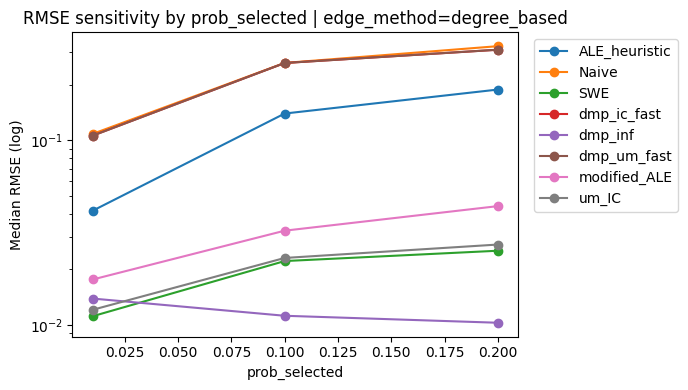

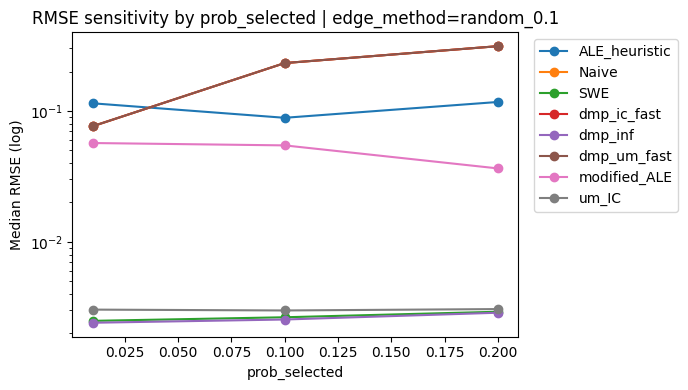

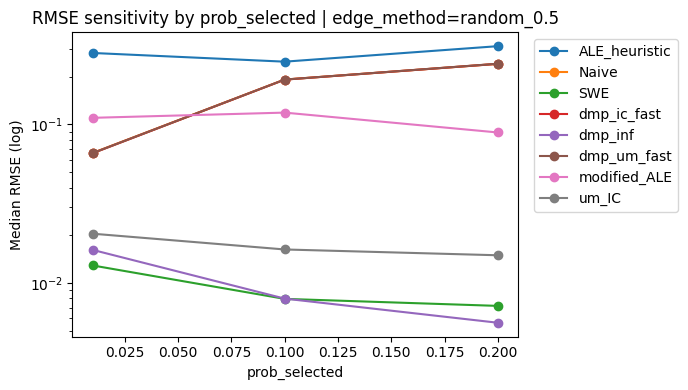

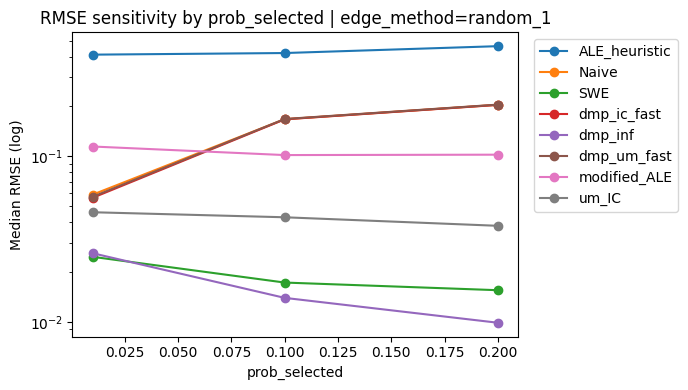

In [66]:
for edge_method, g in df.groupby("edge_method"):
    tmp = (g.groupby(["prob_selected", "approximation"])["rmse"]
             .median()
             .reset_index()
             .sort_values("prob_selected"))

    plt.figure(figsize=(7, 4))
    for appr, gg in tmp.groupby("approximation"):
        plt.plot(gg["prob_selected"], gg["rmse"], marker="o", label=appr)

    plt.yscale("log")
    plt.xlabel("prob_selected")
    plt.ylabel("Median RMSE (log)")
    plt.title(f"RMSE sensitivity by prob_selected | edge_method={edge_method}")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

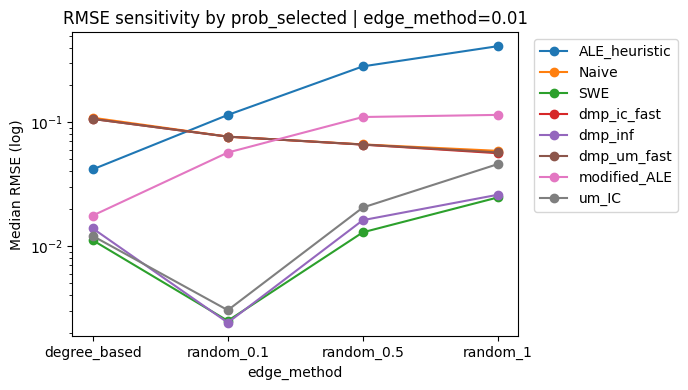

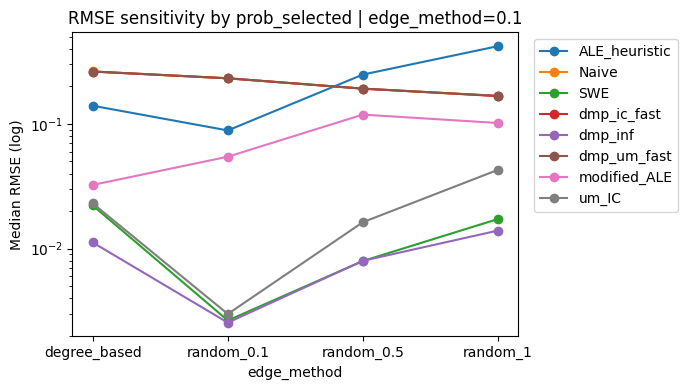

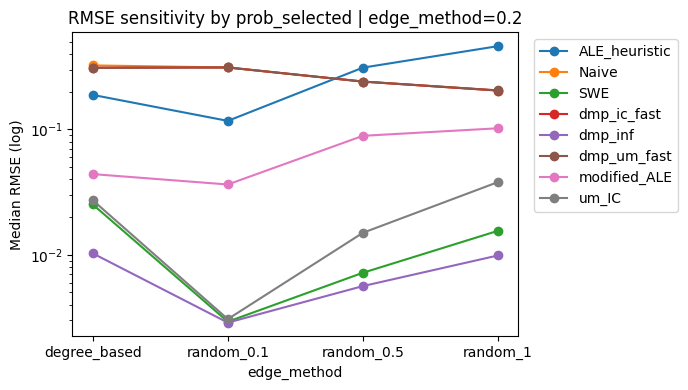

In [68]:
for edge_method, g in df.groupby("prob_selected"):
    tmp = (g.groupby(["edge_method", "approximation"])["rmse"]
             .median()
             .reset_index()
             .sort_values("edge_method"))

    plt.figure(figsize=(7, 4))
    for appr, gg in tmp.groupby("approximation"):
        plt.plot(gg["edge_method"], gg["rmse"], marker="o", label=appr)

    plt.yscale("log")
    plt.xlabel("edge_method")
    plt.ylabel("Median RMSE (log)")
    plt.title(f"RMSE sensitivity by prob_selected | edge_method={edge_method}")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# FF Graphs

In [86]:
DS_ff = pd.read_csv("IC_APPROX_FF.csv")
DS_ff["pearson"] = (
    DS_ff["pearson"]
    .astype(str)
    .str.replace(r"tensor\(|\)", "", regex=True)
    .astype(float)
)

In [90]:
DS_ff.groupby(["approximation"])["pearson"].min()

approximation
ALE_heuristic    0.6408
Naive            0.8565
SWE              0.9067
dmp_ic_fast      0.9660
dmp_inf          0.7706
dmp_um_fast      0.9653
modified_ALE     0.7900
um_IC            0.8873
Name: pearson, dtype: float64

In [91]:
df_ff = DS_ff

if "time_ic_apporx" in df_ff.columns and "time_ic_approx" not in df_ff.columns:
    df_ff = df_ff.rename(columns={"time_ic_apporx": "time_ic_approx"})

df_ff = df_ff.copy()
df_ff["speedup"] = df_ff["time_mc"] / df_ff["time_ic_approx"]
df_ff["log_speedup"] = np.log10(df_ff["speedup"])
df_ff["log_time_ic_approx"] = np.log10(df_ff["time_ic_approx"])

In [115]:
metrics = ["rmse", "spearman", "pearson", "auc", "time_ic_approx", "speedup"]

summary = (df_ff.groupby(["approximation"])
             .agg(
                 rmse_median=("rmse", "median"),
                 spearman_median=("spearman", "median"),
                 time_median=("time_ic_approx", "median"),
                 pearson_median=("pearson", "median"),
                 auc_median=("auc", "median"),
                 speedup_median=("speedup", "median"),
                 time_mc_median=("time_mc", "median")
             )
             .sort_values(["rmse_median", "time_median"])
          )

print(summary)
#summary

               rmse_median  spearman_median  time_median  pearson_median  \
approximation                                                              
dmp_ic_fast       0.003543         0.994993     0.021099         0.99990   
dmp_um_fast       0.003551         0.995156     0.052477         0.99990   
dmp_inf           0.003872         0.994737     0.079696         0.99990   
SWE               0.011944         0.974860     0.009554         0.99830   
Naive             0.015554         0.966357     0.040654         0.99730   
um_IC             0.015619         0.971692     0.009575         0.99730   
modified_ALE      0.041217         0.890719     0.007667         0.99315   
ALE_heuristic     0.097820         0.758039     0.007440         0.96100   

               auc_median  speedup_median  time_mc_median  
approximation                                              
dmp_ic_fast      1.000000      805.184185       17.185834  
dmp_um_fast      1.000000      319.750484       17.185834  

In [117]:
metrics = ["rmse", "spearman", "pearson", "auc", "time_ic_approx", "speedup"]

summary = (df_ff[
                 (df_ff["r"]==0.1)&
                 (df_ff["prob_selected"]==0.01)&
                 (df_ff["edge_method"]=="random_1")].groupby(["approximation"])
             .agg(
                 rmse_median=("rmse", "median"),
                 spearman_median=("spearman", "median"),
                 time_median=("time_ic_approx", "median"),
                 pearson_median=("pearson", "median"),
                 auc_median=("auc", "median"),
                 speedup_median=("speedup", "median"),
                 time_mc_median=("time_mc", "median")
             )
             .sort_values(["rmse_median", "time_median"])
          )

#print(summary)
summary

,rmse_median,spearman_median,time_median,pearson_median,auc_median,speedup_median,time_mc_median
approximation,,,,,,,
dmp_um_fast,0.042931,0.927807,0.053274,0.97855,0.997123,223.610850,11.952917
dmp_ic_fast,0.049912,0.927637,0.022058,0.97695,0.997227,552.390202,11.952917
SWE,0.077859,0.859494,0.011671,0.93845,0.992811,975.886220,11.952917
um_IC,0.084854,0.785569,0.011635,0.92575,0.991579,984.411564,11.952917
Naive,0.095623,0.696055,0.039821,0.90235,0.983600,296.491404,11.952917
modified_ALE,0.121061,0.591341,0.008004,0.84645,0.954376,1503.355619,11.952917
ALE_heuristic,0.169214,0.385882,0.007622,0.70075,0.819759,1580.332214,11.952917
dmp_inf,0.179409,0.898655,0.082298,0.82855,0.982864,144.488435,11.952917


# BA Graphs

In [119]:
DS_ba = pd.read_csv("IC_APPROX_BA.csv")
DS_ba["pearson"] = (
    DS_ba["pearson"]
    .astype(str)
    .str.replace(r"tensor\(|\)", "", regex=True)
    .astype(float)
)

In [127]:
DS_ba.groupby(["approximation"])["rmse"].max()

approximation
ALE_heuristic    0.801037
Naive            0.413365
SWE              0.091708
dmp_ic_fast      0.397389
dmp_inf          0.026076
dmp_um_fast      0.397399
modified_ALE     0.220577
um_IC            0.106976
Name: rmse, dtype: float64

In [124]:
df_ba = DS_ba

if "time_ic_apporx" in df_ba.columns and "time_ic_approx" not in df_ba.columns:
    df_ba = df_ba.rename(columns={"time_ic_apporx": "time_ic_approx"})

df_ba = df_ba.copy()
df_ba["speedup"] = df_ba["time_mc"] / df_ba["time_ic_approx"]
df_ba["log_speedup"] = np.log10(df_ba["speedup"])
df_ba["log_time_ic_approx"] = np.log10(df_ba["time_ic_approx"])

In [126]:
metrics = ["rmse", "spearman", "pearson", "auc", "time_ic_approx", "speedup"]

summary = (df_ba.groupby(["approximation"])
             .agg(
                 rmse_median=("rmse", "median"),
                 spearman_median=("spearman", "median"),
                 time_median=("time_ic_approx", "median"),
                 pearson_median=("pearson", "median"),
                 auc_median=("auc", "median"),
                 speedup_median=("speedup", "median"),
                 time_mc_median=("time_mc", "median")
             )
             .sort_values(["rmse_median", "time_median"])
          )

print(summary)
#summary

               rmse_median  spearman_median  time_median  pearson_median  \
approximation                                                              
dmp_inf           0.003170         0.998027     0.264540         0.99960   
SWE               0.004781         0.994224     0.049855         0.99910   
um_IC             0.009480         0.992180     0.045143         0.99610   
modified_ALE      0.038599         0.910165     0.030767         0.97485   
dmp_ic_fast       0.082811         0.703444     0.117592         0.59230   
dmp_um_fast       0.083276         0.702076     0.127391         0.58820   
Naive             0.083476         0.703964     0.075763         0.59100   
ALE_heuristic     0.171800         0.819696     0.031299         0.90470   

               auc_median  speedup_median  time_mc_median  
approximation                                              
dmp_inf          0.999942      461.873780      137.565916  
SWE              0.999759     2813.447906      137.565916  

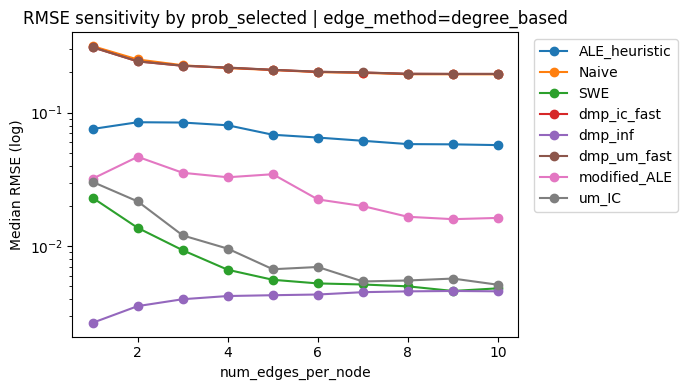

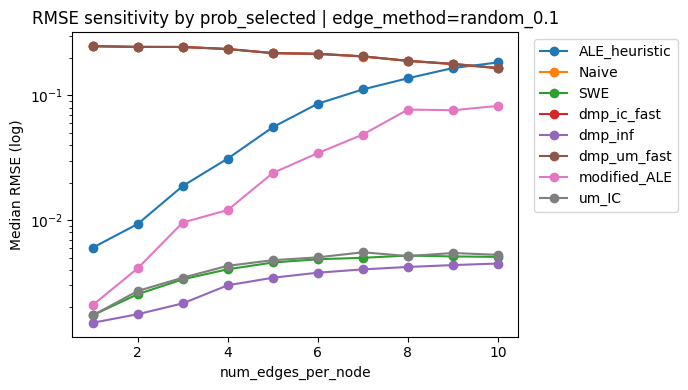

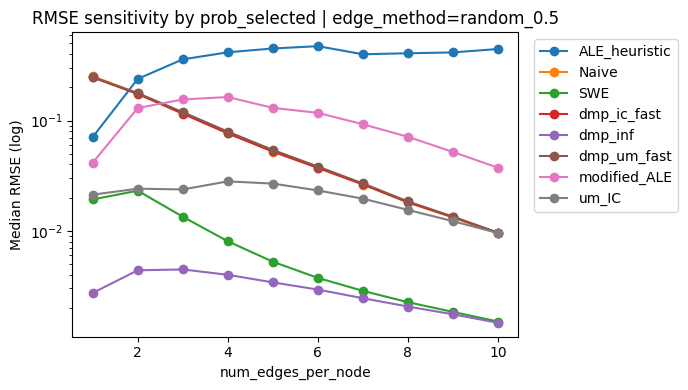

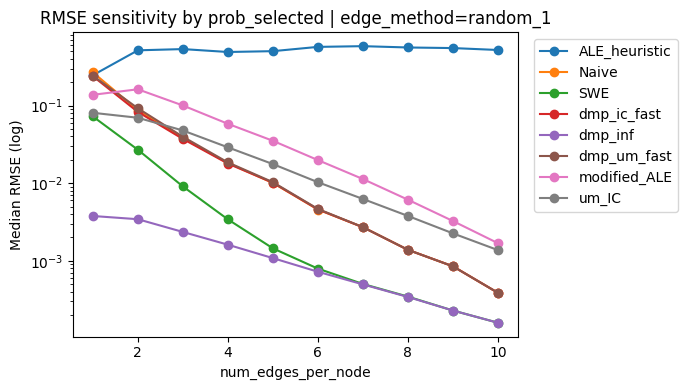

In [129]:
for edge_method, g in df_ba.groupby("edge_method"):
    tmp = (g.groupby(["num_edges_per_node", "approximation"])["rmse"]
             .median()
             .reset_index()
             .sort_values("num_edges_per_node"))

    plt.figure(figsize=(7, 4))
    for appr, gg in tmp.groupby("approximation"):
        plt.plot(gg["num_edges_per_node"], gg["rmse"], marker="o", label=appr)

    plt.yscale("log")
    plt.xlabel("num_edges_per_node")
    plt.ylabel("Median RMSE (log)")
    plt.title(f"RMSE sensitivity by prob_selected | edge_method={edge_method}")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# ER Graphs

In [130]:
DS_er = pd.read_csv("IC_APPROX_ER.csv")
DS_er["pearson"] = (
    DS_er["pearson"]
    .astype(str)
    .str.replace(r"tensor\(|\)", "", regex=True)
    .astype(float)
)

In [131]:
DS_er.groupby(["approximation"])["rmse"].max()

approximation
ALE_heuristic    0.702363
Naive            0.081944
SWE              0.056633
dmp_ic_fast      0.109018
dmp_inf          0.006180
dmp_um_fast      0.142611
modified_ALE     0.166120
um_IC            0.084134
Name: rmse, dtype: float64

In [145]:
DS_er[DS_er["prob_selected"]==0.2].groupby(["approximation"])["rmse"].median()

approximation
ALE_heuristic    0.218007
Naive            0.003128
SWE              0.003078
dmp_ic_fast      0.002665
dmp_inf          0.002666
dmp_um_fast      0.002961
modified_ALE     0.029999
um_IC            0.004424
Name: rmse, dtype: float64

In [132]:
df_er = DS_er

if "time_ic_apporx" in df_er.columns and "time_ic_approx" not in df_er.columns:
    df_er = df_er.rename(columns={"time_ic_apporx": "time_ic_approx"})

df_er = df_er.copy()
df_er["speedup"] = df_er["time_mc"] / df_er["time_ic_approx"]
df_er["log_speedup"] = np.log10(df_er["speedup"])
df_er["log_time_ic_approx"] = np.log10(df_er["time_ic_approx"])

In [134]:
metrics = ["rmse", "spearman", "pearson", "auc", "time_ic_approx", "speedup"]

summary = (df_er.groupby(["approximation"])
             .agg(
                 rmse_median=("rmse", "median"),
                 spearman_median=("spearman", "median"),
                 time_median=("time_ic_approx", "median"),
                 pearson_median=("pearson", "median"),
                 auc_median=("auc", "median"),
                 speedup_median=("speedup", "median"),
                 time_mc_median=("time_mc", "median")
             )
             .sort_values(["rmse_median", "time_median"])
          )

print(summary)
#summary

               rmse_median  spearman_median  time_median  pearson_median  \
approximation                                                              
dmp_inf           0.002093         0.996190     0.260841          0.9999   
dmp_ic_fast       0.002136         0.995726     0.122131          0.9999   
dmp_um_fast       0.002476         0.995074     0.131590          0.9998   
SWE               0.002561         0.994593     0.048538          0.9997   
Naive             0.002670         0.993547     0.076279          0.9997   
um_IC             0.004563         0.993297     0.044099          0.9994   
modified_ALE      0.015374         0.957798     0.034249          0.9920   
ALE_heuristic     0.127515         0.878488     0.033674          0.9871   

               auc_median  speedup_median  time_mc_median  
approximation                                              
dmp_inf          0.999989      392.478567       105.08401  
dmp_ic_fast      0.999988      951.115130       105.08401  

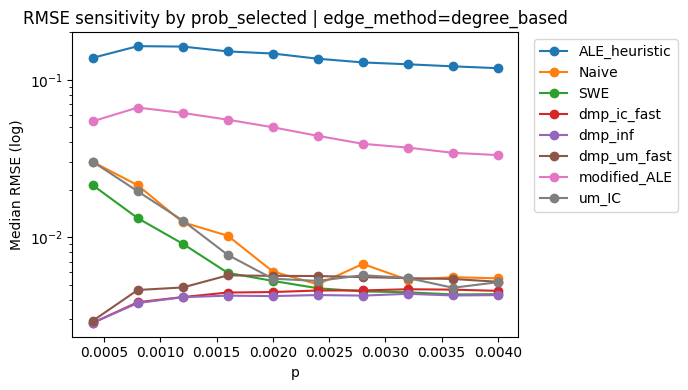

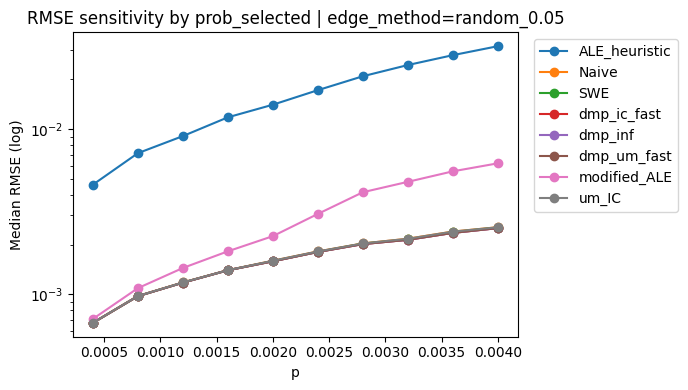

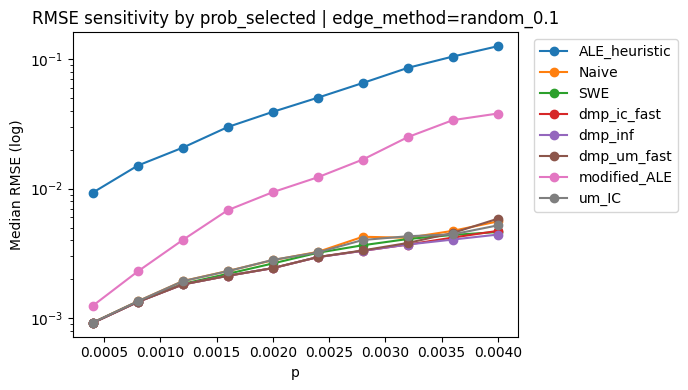

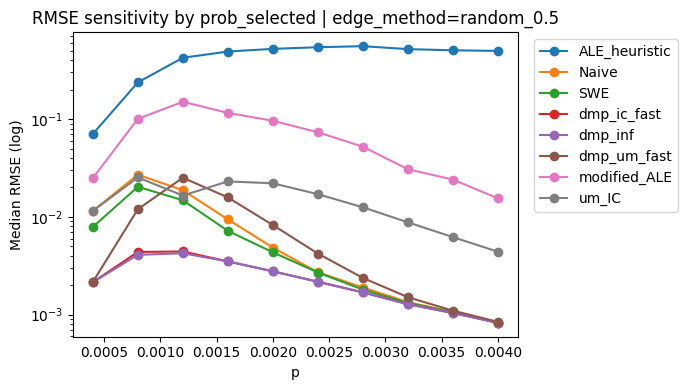

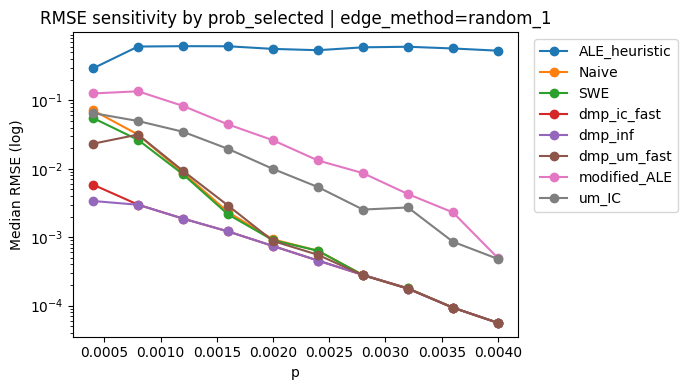

In [147]:
for edge_method, g in df_er.groupby("edge_method"):
    tmp = (g.groupby(["p", "approximation"])["rmse"]
             .median()
             .reset_index()
             .sort_values("p"))

    plt.figure(figsize=(7, 4))
    for appr, gg in tmp.groupby("approximation"):
        plt.plot(gg["p"], gg["rmse"], marker="o", label=appr)

    plt.yscale("log")
    plt.xlabel("p")
    plt.ylabel("Median RMSE (log)")
    plt.title(f"RMSE sensitivity by prob_selected | edge_method={edge_method}")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()